# Graph algorithms with `networkx`

In [1]:
import kglab

namespaces = {
    "wtm": "http://purl.org/heals/food/",
    "ind": "http://purl.org/heals/ingredient/",
    }

kg = kglab.KnowledgeGraph(
    name = "A recipe KG example based on Food.com",
    base_uri = "https://www.food.com/recipe/",
    language = "en",
    namespaces = namespaces,
    )

kg.load_ttl("tmp.ttl")

In [2]:
import networkx as nx

# query to yield a subgraph of recipe URLs and ingredients
query = """
        SELECT ?rec ?ind
           WHERE {
              ?rec rdf:type wtm:Recipe .
              ?rec wtm:hasIngredient ?ind .
           }
        """

# use result set from query to load NetworkX graph
g = nx.Graph()

for row in kg.query(query):
    rec, ind = row

    s_label = rec.n3(kg._g.namespace_manager)
    s_id = kg.get_node_id(rec)

    o_label = ind.n3(kg._g.namespace_manager)
    o_id = kg.get_node_id(ind)

    print("{}: {}\n {}: {}\n".format(s_id, s_label, o_id, o_label))

    g.add_node(s_id, bipartite=0)
    g.add_node(o_id, bipartite=1)
    g.add_edge(s_id, o_id)

0: <https://www.food.com/recipe/12055>
 1: ind:Butter

0: <https://www.food.com/recipe/12055>
 2: ind:Salt

0: <https://www.food.com/recipe/12055>
 3: ind:CowMilk

0: <https://www.food.com/recipe/12055>
 4: ind:ChickenEgg

0: <https://www.food.com/recipe/12055>
 5: ind:AllPurposeFlour

0: <https://www.food.com/recipe/12055>
 6: ind:Water

7: <https://www.food.com/recipe/91311>
 5: ind:AllPurposeFlour

7: <https://www.food.com/recipe/91311>
 2: ind:Salt

7: <https://www.food.com/recipe/91311>
 4: ind:ChickenEgg

7: <https://www.food.com/recipe/91311>
 3: ind:CowMilk

8: <https://www.food.com/recipe/103964>
 3: ind:CowMilk

8: <https://www.food.com/recipe/103964>
 4: ind:ChickenEgg

8: <https://www.food.com/recipe/103964>
 6: ind:Water

8: <https://www.food.com/recipe/103964>
 2: ind:Salt

8: <https://www.food.com/recipe/103964>
 5: ind:AllPurposeFlour

8: <https://www.food.com/recipe/103964>
 1: ind:Butter

8: <https://www.food.com/recipe/103964>
 9: ind:BlackPepper

10: <https://www.fo

In [3]:
nx.is_connected(g)

True

In [4]:
from networkx.algorithms import bipartite

rec_nodes, ind_nodes = bipartite.sets(g)
ind_nodes

{1, 2, 3, 4, 5, 6, 9, 19, 20, 23, 36, 53}

In [5]:
results = nx.onion_layers(g)

for node_id, core_number in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if node_id in ind_nodes:
        node = kg.get_node(node_id)
        print("{:6.3f} {}".format(core_number, kg.get_node_label(node)))

14.000 ind:Butter
14.000 ind:Salt
14.000 ind:CowMilk
14.000 ind:ChickenEgg
14.000 ind:AllPurposeFlour
12.000 ind:BlackPepper
12.000 ind:Water
 9.000 ind:OliveOil
 6.000 ind:WholeWheatFlour
 3.000 ind:Garlic
 3.000 ind:AppleCiderVinegar
 3.000 ind:Honey


In [6]:
results = nx.degree_centrality(g)
ind_rank = {}

for node_id, rank in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if node_id in ind_nodes:
        node = kg.get_node(node_id)
        ind_rank[node_id] = rank
        print("{:6.3f} {}".format(rank, kg.get_node_label(node)))

 0.645 ind:ChickenEgg
 0.585 ind:Salt
 0.568 ind:AllPurposeFlour
 0.432 ind:CowMilk
 0.399 ind:Butter
 0.383 ind:Water
 0.093 ind:OliveOil
 0.071 ind:Garlic
 0.060 ind:BlackPepper
 0.055 ind:WholeWheatFlour
 0.049 ind:Honey
 0.027 ind:AppleCiderVinegar


In [7]:
import networkx.algorithms.distance_measures as nx_measure

nx_measure.diameter(g)

5

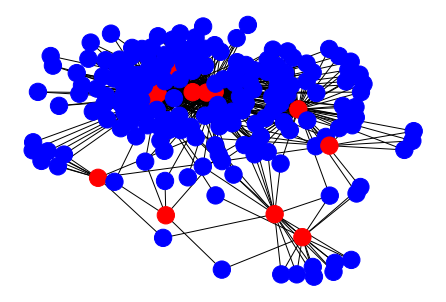

In [8]:
import matplotlib.pyplot as plt

color = [ "red" if n in ind_nodes else "blue" for n in g.nodes()]

nx.draw(g, node_color=color, with_labels=False)
plt.show()

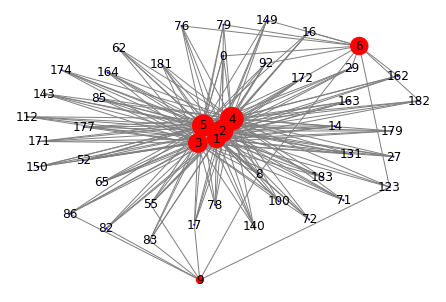

In [9]:
core_g = nx.k_core(g)
color = [ "red" if n in ind_nodes else "blue" for n in core_g ]
size = [ ind_rank[n] * 800 if n in ind_nodes else 1 for n in core_g ]

nx.draw(core_g, node_color=color, node_size=size, edge_color="gray", with_labels=True)
plt.show()

In [10]:
for node_id, rank in sorted(ind_rank.items(), key=lambda item: item[1], reverse=True):
    if node_id in core_g:
        node = kg.get_node(node_id)
        print("{:3} {:6.3f} {}".format(node_id, rank, kg.get_node_label(node)))

  4  0.645 ind:ChickenEgg
  2  0.585 ind:Salt
  5  0.568 ind:AllPurposeFlour
  3  0.432 ind:CowMilk
  1  0.399 ind:Butter
  6  0.383 ind:Water
  9  0.060 ind:BlackPepper


In [11]:
page_rank = nx.pagerank(g)

for node_id, rank in sorted(ind_rank.items(), key=lambda item: item[1], reverse=True):
    if node_id in core_g:
        node = kg.get_node(node_id)
        label = kg.get_node_label(node)
        print("{:3} {:6.3f} {:6.3f} {}".format(node_id, rank, page_rank[node_id], label))

  4  0.645  0.088 ind:ChickenEgg
  2  0.585  0.076 ind:Salt
  5  0.568  0.074 ind:AllPurposeFlour
  3  0.432  0.056 ind:CowMilk
  1  0.399  0.054 ind:Butter
  6  0.383  0.055 ind:Water
  9  0.060  0.008 ind:BlackPepper
